# Estimation on real data using MSM

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt

# Singles

In [2]:
def weight_matrix(std):
    std_inv = np.zeros(std.shape)
    idx = np.nonzero(std>0)[0]
    std_inv[idx] = 1/std[idx]
    return np.eye(std.size)*std_inv

moments = pd.read_excel('SASdata/single_moments.xlsx')
mom_data = moments['Moments'].to_numpy()
weight = weight_matrix(moments['SE'].to_numpy())

Set up estimation

In [3]:
Single = RetirementClass(simN=int(1e5), simT=12)
Single.solve()
Single.simulate()

In [4]:
# function to generate moments
def mom_fun(sim):
    return SMD.MomFunSingle(sim,Single.par)

In [7]:
# Parameters to be estimated (and guess)
theta0 = [(0.1, 0.1, 0.1, 0.1, 0.5),
          (0.5, 0.5, 0.2, 0.2, 0.5),
          (1.0, 1.0, 0.3, 0.3, 0.5),
          (0.1, 0.1, -0.1, 0.1, 0.5),
          (0.5, 0.5, -0.2, 0.2, 0.5),
          (1.0, 1.0, -0.3, 0.3, 0.5)]

add_str = '_est'
est_par = ("alpha_0_male", "alpha_0_female", "alpha_1", "alpha_2", "sigma_eta")
est_par_tex = (r'$\alpha_0^m$', r'$\alpha_0^f$', r'$\alpha_1^m$', r'$\alpha_1^f', r'$\alpha_2$', r'$\sigma$')
fixed_par = ('R', 'rho', 'beta', 'gamma', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f')
fixed_par_tex = (r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', r'$g$', r'$\pi_m$', r'$\pi_f$')

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Single,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [ ]:
smd.MultiStart(theta0,weight)
theta = smd.est

1 estimation:
success: True | feval: 286 | time: 5.2 min | obj: 0.7609386043843205
start par: (0.1, 0.1, 0.1, 0.1, 0.5)
par:       [ 0.43625086  0.44180626 -0.18855116  0.35570321  0.28082156]



In [10]:
smd.MultiStart(theta0,weight)
theta = smd.est

1 estimation:
success: True | feval: 192 | time: 2.9 min | obj: 1.4628792100557835
start par: (0.1, 0.1, 0.2, 0.5)
par:       [ 0.44850498  0.53427819 -0.12925977  0.25811005]

2 estimation:
success: True | feval: 183 | time: 2.7 min | obj: 1.4084938553095876
start par: (0.5, 0.5, 0.2, 0.5)
par:       [ 0.47918639  0.48786538 -0.14123477  0.27401877]

3 estimation:
success: True | feval: 174 | time: 2.5 min | obj: 1.6924792808369395
start par: (1.0, 1.0, -0.2, 0.5)
par:       [ 0.58098028  0.58031853 -0.31365476  0.38353661]

4 estimation:
success: True | feval: 171 | time: 2.5 min | obj: 2.086815922927607
start par: (1.5, 1.5, -0.2, 0.5)
par:       [ 0.61809415  0.60169744 -0.21842198  1.19080926]

5 estimation:
success: True | feval: 313 | time: 4.7 min | obj: 1.412295324332254
start par: (1.0, 1.0, 0.2, 0.5)
par:       [ 0.47956302  0.5017082  -0.14748736  0.27040003]

final estimation:
success: True | feval: 86 | obj: 1.4085391737494632
total estimation time: 0.3 hours
start par: [

### Results

In [ ]:
Nobs = 5000
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Single.par.simN/Nobs)
std_error = smd.std
print('Parameters:', theta)
print('Std error :', std_error)
SMD.save_est(est_par,theta,name='Single') # save parameters

In [11]:
Nobs = 5000
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Single.par.simN/Nobs)
std_error = smd.std
print('Parameters:', theta)
print('Std error :', std_error)
SMD.save_est(est_par,theta,name='Single') # save parameters

Parameters: [ 0.47918639  0.48786538 -0.14123477  0.27401877]
Std error : [0.0070615  0.00236628 0.00166265 0.00568485]


### Model fit

In [3]:
theta = SMD.load_est(name='Single')
est_par = ("alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta")
th = []
for p in range(len(theta)):
    th.append(theta[est_par[p]])
theta = th

In [17]:
for p in range(len(est_par)):
    setattr(Single.par,est_par[p],theta[p]) 
Single.solve()
Single.simulate()

In [20]:
G0 = figs.retirement_probs(Single,MA=[0])
G1 = figs.retirement_probs(Single,MA=[1])

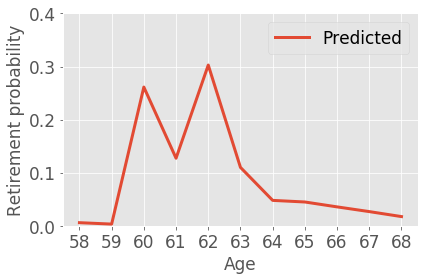

In [24]:
figs.MyPlot(G0,linewidth=3,ylim=[0,0.4],save=False)

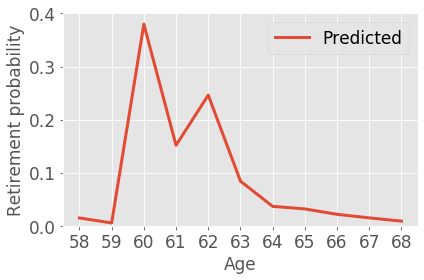

In [25]:
figs.MyPlot(G1,linewidth=3,ylim=[0,0.4],save=False)

In [12]:
import transitions
def mom(df,ma,st,par):
    return df[(df['Køn (mand)'] == ma) & (df['Adgang til efterløn'] == transitions.state_translate(st,'elig',par)) & 
              (df['High skilled'] == transitions.state_translate(st,'high_skilled',par))]['Moments'].to_numpy()

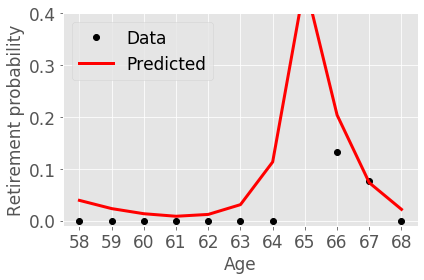

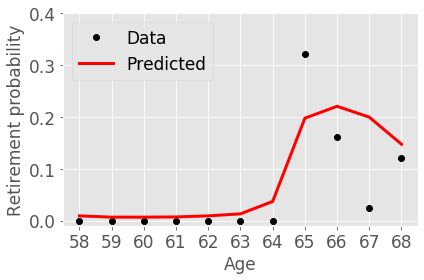

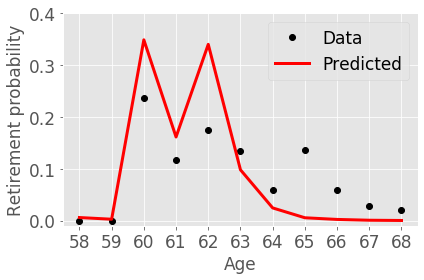

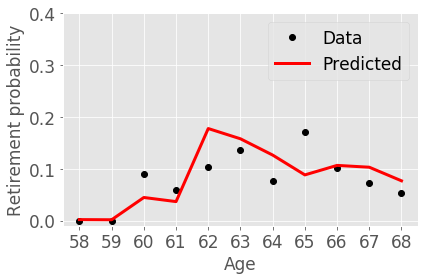

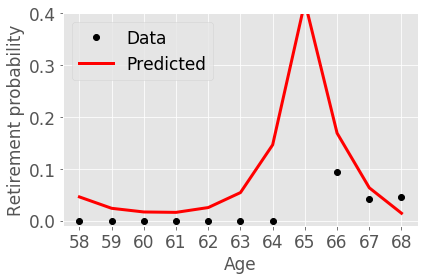

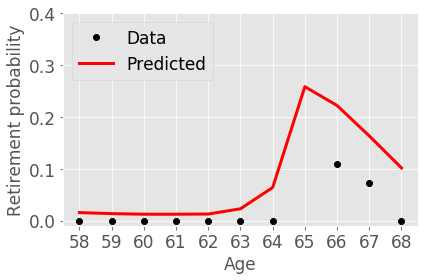

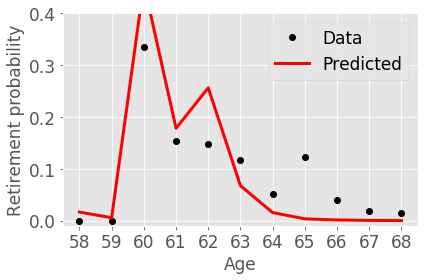

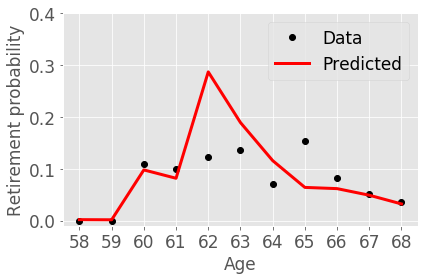

In [13]:
for ma in [0,1]:
    for st in [0,1,2,3]:
        G_data = {'y': [mom(moments,ma,st,Single.par)], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k', 
              'linestyle': ['None'], 'marker': 'o'}
        G_pred = figs.retirement_probs(Single,MA=[ma],ST=[st])
        G_pred['color'] = 'red'
        figs.MyPlot([G_data,G_pred],ylim=[-0.01,0.4],linewidth=3,save=False)

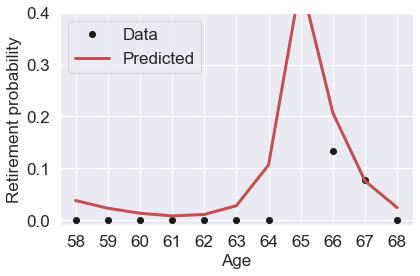

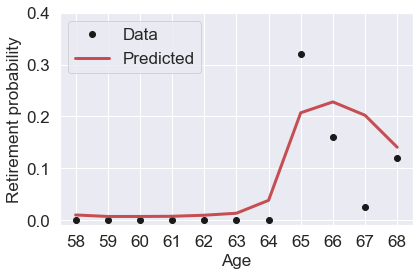

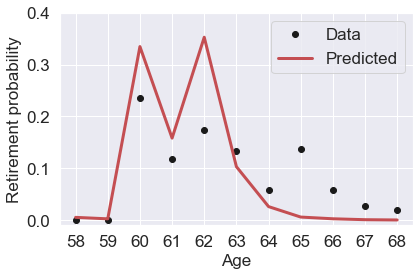

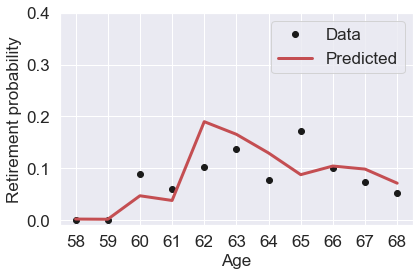

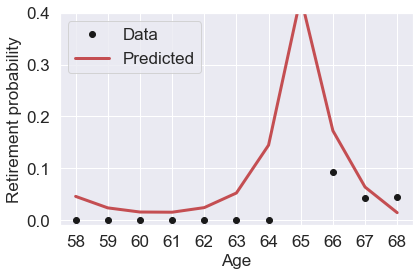

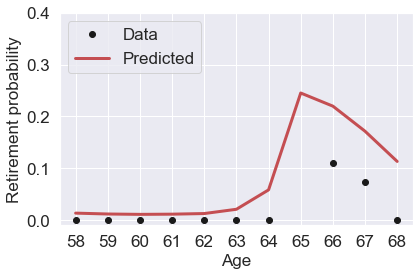

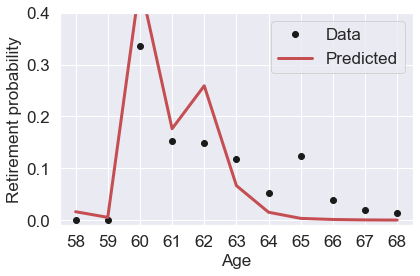

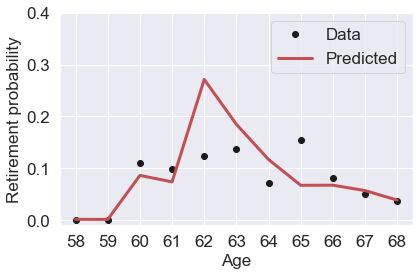

In [40]:
for ma in [0,1]:
    for st in [0,1,2,3]:
        G_data = {'y': [mom(moments,ma,st,Single.par)], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k', 
              'linestyle': ['None'], 'marker': 'o'}
        G_pred = figs.retirement_probs(Single,MA=[ma],ST=[st])
        G_pred['color'] = 'red'
        figs.MyPlot([G_data,G_pred],ylim=[-0.01,0.4],linewidth=3,save=False)

In [33]:
def mom_data_total(MA):
    data = pd.read_excel('SASdata/single_moments_total.xlsx')
    mom = np.reshape(data['Moments'].to_numpy(), newshape=(int(len(data)/3),3), order='F')
    if len(MA)>1:
        return mom[:,-1]
    else:
        return mom[:,MA[0]]
    
def model_fit(MA):
    G_data = {'y': [mom_data_total(MA=MA)], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k', 
              'linestyle': ['None'], 'marker': 'o'}
    G_pred = figs.retirement_probs(Single,MA=MA)
    #G_pred['color'] = 'red'
    return [G_data,G_pred]

Women

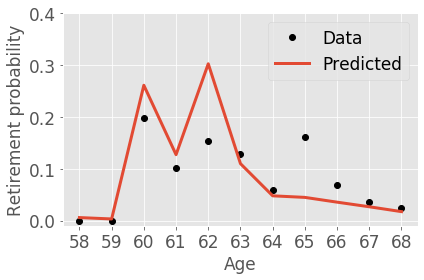

In [34]:
figs.MyPlot(model_fit([0]),ylim=[-0.01,0.4],linewidth=3,save=True).savefig('figs/ModelFit/SingleWomen.png')

Men

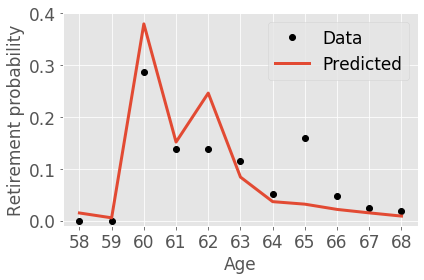

In [35]:
figs.MyPlot(model_fit([1]),ylim=[-0.01,0.4],linewidth=3,save=True).savefig('figs/ModelFit/SingleMen.png')

### Sensitivity

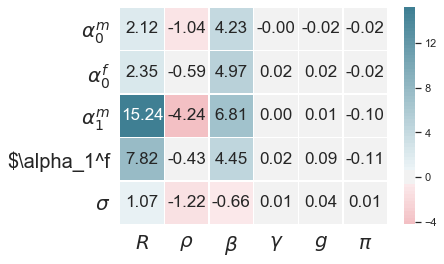

In [14]:
smd.recompute = True # because g_adjust and pi_adjust requires recompute
smd.sensitivity(theta,weight,fixed_par)
figs.sens_fig_tab(smd.sens2,smd.sens2e,theta,est_par_tex,fixed_par_tex)

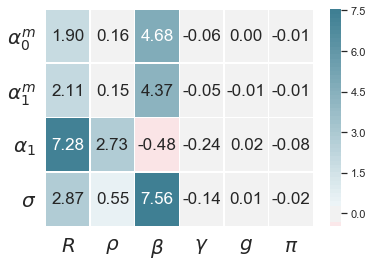

In [28]:
smd.recompute = True # because g_adjust and pi_adjust requires recompute
smd.sensitivity(theta,weight,fixed_par)
figs.sens_fig_tab(smd.sens2,smd.sens2e,theta,est_par_tex,fixed_par_tex)

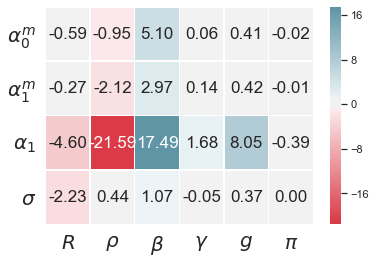

In [12]:
smd.recompute = True # because g_adjust and pi_adjust requires recompute
smd.sensitivity(theta,weight,fixed_par)
figs.sens_fig_tab(smd.sens2,smd.sens2e,theta,est_par_tex,fixed_par_tex)

Clean up

In [ ]:
%reset -f

# Couples

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt

Generate or load data

In [2]:
load = False # if load, we load in real data else we simulate data from the model

In [3]:
# create weight matrix
def weight_matrix(std):
    std_inv = np.zeros(std.shape)
    idx = np.nonzero(std>0.01)[0]
    std_inv[idx] = 1/std[idx]
    return np.eye(std.size)*std_inv

if load:
    moments = pd.read_excel('SASdata/couple_moments.xlsx')
    mom_h = moments['Moments_H'].to_numpy()
    mom_w = moments['Moments_W'].to_numpy()
    se_h = moments['SE_H'].to_numpy()
    se_w = moments['SE_H'].to_numpy()
    mom_data = np.hstack((mom_h,mom_w))
    weight = weight_matrix(np.hstack((se_h,se_w)))    
else:
    single_kwargs = {'sim_seed': 2020, 'simN': 2000000}
    couple_kwargs = {'sim_seed': 2019, 'simN': 2000000}
    Couple = RetirementClass(couple=True, single_kwargs=single_kwargs, **couple_kwargs)
    Couple.solve()
    Couple.par.simT = 12 # 68-51+1    
    Couple.simulate()
    mom_data = funs.MomFunCouple(Couple.sim,Couple.par)
    mom_se = funs.MomFunCouple(Couple.sim,Couple.par,std=True)
    weight = weight_matrix(mom_se)

C:\Users\Frederik\Desktop\speciale\Speciale_retirement\Main\funs.py:68: RuntimeWarning: Mean of empty slice
  mom[1,:,i] = np.nanmean(probs_w[idx,:],axis=0)
C:\Users\Frederik\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Set up estimation

In [4]:
if not load:
    del Couple # on my computer with 8GB RAM it is not possible to have 2 classes of Couple due to memory error

In [5]:
single_kwargs = {'sim_seed': 100, 'simN': 1000000}
couple_kwargs = {'sim_seed': 200, 'simN': 1000000}
Couple = RetirementClass(couple=True, single_kwargs=single_kwargs, **couple_kwargs)
Couple.solve()
Couple.par.simT = 12 # 68-51+1
Couple.simulate()

In [6]:
# function to generate moments
def mom_fun(sim):
    return funs.MomFunCouple(sim,Couple.par)

In [28]:
if not load: # simulated data (we know the true parameters)
    true = [Couple.par.alpha_0_male, Couple.par.alpha_0_female, Couple.par.alpha_1, Couple.par.sigma_eta, 
            Couple.par.phi_0_male, Couple.par.phi_0_female, Couple.par.phi_1]

theta0 = [0.5, 0.5, 0.1, 0.5, 1, 1, 0.1]
add_str = '_est'
est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta", "phi_0_male", "phi_0_female", "phi_1"]

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun,print_iter=[True,1],save=True,options={'disp':True})
smd.est_par = est_par
smd.est_par_save = {'{}'.format(i):[] for i in est_par}
smd.est_par_save['obj_func'] = []

Run estimation

In [29]:
tic = time.time()
smd.estimate(theta0,weight)
theta = smd.est
toc = time.time()

Iteration: 1 (0.09 minutes)
 alpha_0_male=0.5000 alpha_0_female=0.5000 alpha_1=0.1000 sigma_eta=0.5000 phi_0_male=1.0000 phi_0_female=1.0000 phi_1=0.1000

C:\Users\Frederik\Desktop\speciale\Speciale_retirement\Main\funs.py:68: RuntimeWarning: Mean of empty slice
  mom[1,:,i] = np.nanmean(probs_w[idx,:],axis=0)


 -> 1036736.2266
Iteration: 2 (0.42 minutes)
 alpha_0_male=0.5250 alpha_0_female=0.5000 alpha_1=0.1000 sigma_eta=0.5000 phi_0_male=1.0000 phi_0_female=1.0000 phi_1=0.1000 -> 1148786.7339
Iteration: 3 (0.43 minutes)
 alpha_0_male=0.5000 alpha_0_female=0.5250 alpha_1=0.1000 sigma_eta=0.5000 phi_0_male=1.0000 phi_0_female=1.0000 phi_1=0.1000 -> 1147249.3674
Iteration: 4 (0.43 minutes)
 alpha_0_male=0.5000 alpha_0_female=0.5000 alpha_1=0.1050 sigma_eta=0.5000 phi_0_male=1.0000 phi_0_female=1.0000 phi_1=0.1000 -> 1062668.9184
Iteration: 5 (0.43 minutes)
 alpha_0_male=0.5000 alpha_0_female=0.5000 alpha_1=0.1000 sigma_eta=0.5250 phi_0_male=1.0000 phi_0_female=1.0000 phi_1=0.1000 -> 1010899.8888
Iteration: 6 (0.45 minutes)
 alpha_0_male=0.5000 alpha_0_female=0.5000 alpha_1=0.1000 sigma_eta=0.5000 phi_0_male=1.0500 phi_0_female=1.0000 phi_1=0.1000 -> 1100918.7386
Iteration: 7 (0.44 minutes)
 alpha_0_male=0.5000 alpha_0_female=0.5000 alpha_1=0.1000 sigma_eta=0.5000 phi_0_male=1.0000 phi_0_female

Results

In [30]:
print('Parameter:       ', est_par)
print('Estimated:       ', np.round(theta, 4))
if not load:
    print('True:            ', np.round(true, 4))
    print('bias:            ', np.round(theta-true, 4))
print('Estimation time: ', round((toc-tic)/(60**2),2), 'hours')

Parameter:        ['alpha_0_male', 'alpha_0_female', 'alpha_1', 'sigma_eta', 'phi_0_male', 'phi_0_female', 'phi_1']
Estimated:        [0.149  0.1877 0.0067 0.4459 2.611  0.1225 0.1839]
True:             [0.5 0.5 0.1 0.5 1.  1.  0.1]
bias:             [-0.351  -0.3123 -0.0933 -0.0541  1.611  -0.8775  0.0839]
Estimation time:  3.89 hours


Save results

In [31]:
funs.save_est(est_par,theta,name='Couple')

Model fit

In [33]:
for p in range(len(est_par)):
    setattr(Couple.par,est_par[p],theta[p]) 
    if hasattr(Couple.Single.par,est_par[p]):
        setattr(Couple.Single.par,est_par[p],theta[p]) 
Couple.solve()
Couple.simulate()

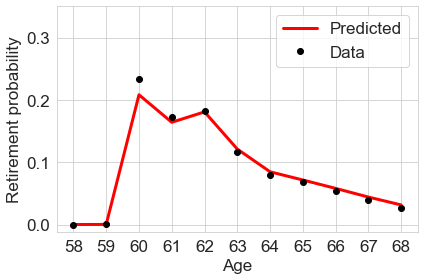

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.retirement_probs_c(Couple,ax,ma=1,moments=True)
fig.tight_layout()
fig.savefig('figs/ModelFit/FullCoupleMen.png')

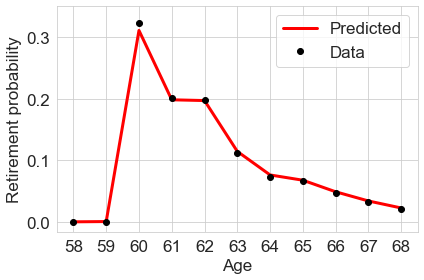

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.retirement_probs_c(Couple,ax,ma=0,moments=True)
fig.tight_layout()
fig.savefig('figs/ModelFit/FullCoupleWomen.png')

Clean up

In [ ]:
%reset -f

# Restricted Couple model

In [ ]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import funs
import figs
import transitions
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

Generate or load data

In [ ]:
load = False

In [ ]:
# create weight matrix
def weight_matrix(std):
    std_inv = np.zeros(std.shape)
    idx = np.nonzero(std>0.01)[0]
    std_inv[idx] = 1/std[idx]
    return np.eye(std.size)*std_inv

if load:
    moments = pd.read_excel('SASdata/couple_moments.xlsx')
    mom_h = moments['Moments_H'].to_numpy()
    mom_w = moments['Moments_W'].to_numpy()
    se_h = moments['SE_H'].to_numpy()
    se_w = moments['SE_H'].to_numpy()
    mom_data = np.hstack((mom_h,mom_w))
    weight = weight_matrix(np.hstack((se_h,se_w)))    
else:
    single_kwargs = {'sim_seed': 2020, 'simN': 2000000}
    couple_kwargs = {'sim_seed': 2019, 'simN': 2000000}
    Couple = RetirementClass(couple=True, single_kwargs=single_kwargs, **couple_kwargs)
    Couple.par.simT = 12 # 68-51+1
    Couple.solve()
    Couple.simulate()
    mom_data = funs.MomFunCouple(Couple.sim,Couple.par)
    mom_se = funs.MomFunCouple(Couple.sim,Couple.par,std=True)
    weight = weight_matrix(mom_se)

Set up estimation

In [ ]:
if not load:
    del Couple

In [ ]:
single_kwargs = {'sim_seed': 100, 'simN': 2000000}
couple_kwargs = {'sim_seed': 200, 'simN': 2000000, , 'phi_0_male': 0.0, 'phi_0_female': 0.0, 'phi_1': 0.0}
Couple = RetirementClass(couple=True, single_kwargs=single_kwargs, **couple_kwargs)
Couple.par.simT = 12 # 68-51+1
Couple.solve()
Couple.simulate()

In [ ]:
# function to generate moments
def mom_fun(sim):
    return funs.MomFunCouple(sim,Couple.par)

In [ ]:
if not load: # simulated data (we know the true parameters)
    true = [Couple.par.alpha_0_male, Couple.par.alpha_0_female, Couple.par.alpha_1, Couple.par.sigma_eta]

theta0 = [0.5, 0.5, 0.1, 0.5]
add_str = '_est'
est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta"]

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun,print_iter=[True,50],save=True,options={'disp':True})
smd.est_par = est_par
smd.est_par_save = {'{}'.format(i):[] for i in est_par}
smd.est_par_save['obj_func'] = []

Run estimation

In [ ]:
tic = time.time()
smd.estimate(theta0,weight)
theta = smd.est
toc = time.time()

Results

In [ ]:
print('Parameter:       ', est_par)
print('Estimated:       ', np.round(theta, 4))
if not load:
    print('True:            ', np.round(true, 4))
    print('bias:            ', np.round(theta-true, 4))
print('Estimation time: ', round((toc-tic)/(60**2),2), 'hours')

Save results

In [ ]:
funs.save_est(est_par,theta,name='RestCouple')

Model fit

In [ ]:
for p in range(len(est_par)):
    setattr(Couple.par,est_par[p],theta_base[p]) 
    if hasattr(Couple.Single.par,est_par[p]):
        setattr(Couple.Single.par,est_par[p],theta_base[p]) 
Couple.solve()
Couple.simulate()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.retirement_probs_c(Couple,ax,ma=1,moments=True)
fig.tight_layout()
fig.savefig('figs/ModelFit/RestCoupleMen.png')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.retirement_probs_c(Couple,ax,ma=0,moments=True)
fig.tight_layout()
fig.savefig('figs/ModelFit/RestCoupleWomen.png')